In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import pickle
import random
import collections
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns
from dime_take_home.utils import get_locations_from_text

2025-09-13 13:31:16.813 | INFO     | dime_take_home.config:<module>:11 - PROJ_ROOT path is: /Users/alexisrutherford/dime_take_home


In [98]:
with open("../data/raw/id_english_location_name.pkl", "rb") as f:
    locations_dict_en = pickle.load(f)

with open("../data/raw/id_arabic_location_name.pkl", "rb") as f:
    locations_dict_ar = pickle.load(f)
    
with open("../data/processed/en_locations_reversed.pkl", "rb") as f:
    locations_dict_en_reversed = pickle.load(f)
    
with open("../data/processed/ar_locations_reversed.pkl", "rb") as f:
    locations_dict_ar_reversed = pickle.load(f)


In [36]:
df_news_ar = pd.read_csv("../data/processed/news_articles_augmented_ar.csv")
df_news_en = pd.read_csv("../data/processed/news_articles_augmented_en.csv")

In [37]:
df_news_en['locations'] = df_news_en['locations'].apply(eval)
df_news_en['risk_factors'] = df_news_en['risk_factors'].apply(eval)
df_news_en['dateTime'] = pd.to_datetime(df_news_en['dateTime'])

df_news_ar['locations'] = df_news_ar['locations'].apply(eval)
df_news_ar['risk_factors'] = df_news_ar['risk_factors'].apply(eval)
df_news_ar['dateTime'] = pd.to_datetime(df_news_ar['dateTime'])

In [38]:
df_news_en.shape[0], df_news_ar.shape[0]

(8084, 4180)

## Check out prevalence of language clusters over time for EN/AR

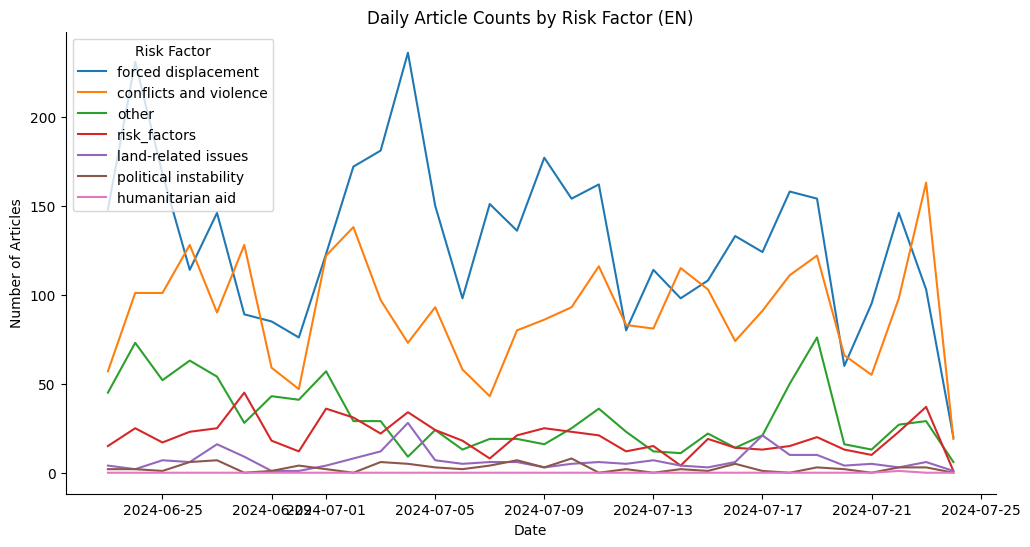

<Figure size 640x480 with 0 Axes>

In [39]:
_ = plt.figure(figsize=(12,6))

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

counter = collections.Counter(rf for rfs in df_news_en['risk_factors'] for rf in rfs)

for risk_factor, v in counter.most_common():
    daily_counts = df_news_en['risk_factors'].map(lambda rfs: risk_factor in rfs).groupby(df_news_en['dateTime'].dt.date).sum()
    daily_counts.plot(label=risk_factor)

plt.legend(title="Risk Factor")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Article Counts by Risk Factor (EN)")
plt.show()

_ = plt.savefig("../reports/figures/daily_article_counts_by_risk_factor.png", bbox_inches='tight',dpi = 300)

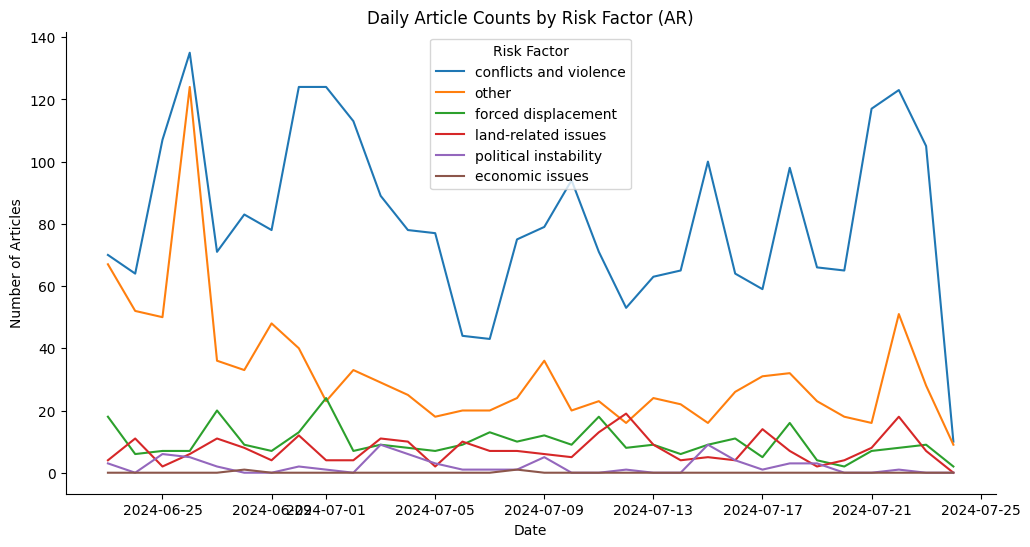

<Figure size 640x480 with 0 Axes>

In [40]:
_ = plt.figure(figsize=(12,6))

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

counter = collections.Counter(rf for rfs in df_news_ar['risk_factors'] for rf in rfs)

for risk_factor, v in counter.most_common():
    daily_counts = df_news_ar['risk_factors'].map(lambda rfs: risk_factor in rfs).groupby(df_news_ar['dateTime'].dt.date).sum()
    daily_counts.plot(label=risk_factor)

plt.legend(title="Risk Factor")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Article Counts by Risk Factor (AR)")
plt.show()

_ = plt.savefig("../reports/figures/daily_article_counts_by_risk_factor_ar.png", bbox_inches='tight',dpi = 300)

The prevalence of different clusters in English and Arabic are quite different. Points to a potential bias if using one source or another or possibly limitations in one or another taxonomy.

## Check out prevalence of countries over time for EN/AR

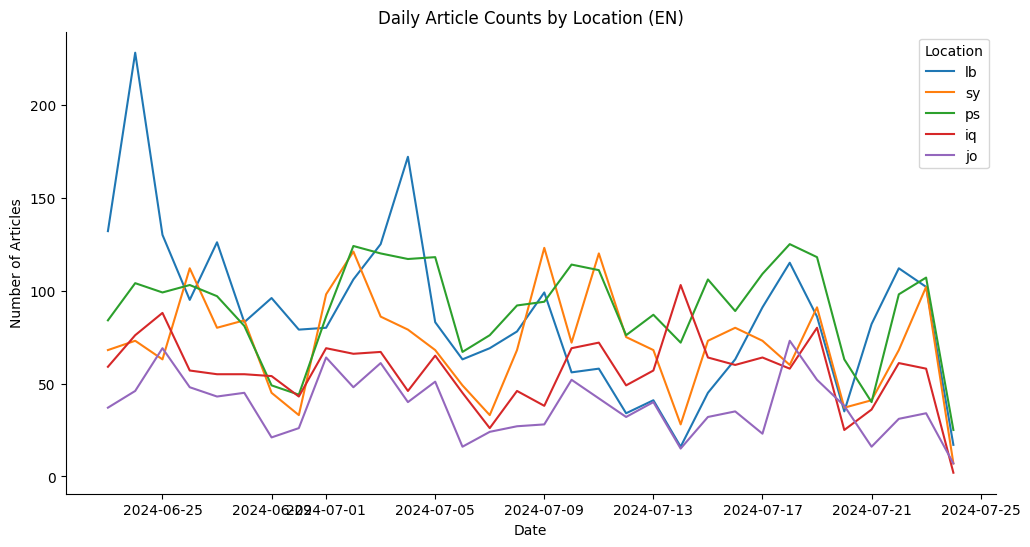

<Figure size 640x480 with 0 Axes>

In [46]:
_ = plt.figure(figsize=(12,6))

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

counter = collections.Counter(l for locs in df_news_en['locations'] for l in locs)
counter = collections.Counter({k: v for k, v in counter.items() if len(k) == 2})  

# Just look at admin 0 for now

for location, v in counter.most_common():
    daily_counts = df_news_en['locations'].map(lambda rfs: location in rfs).groupby(df_news_en['dateTime'].dt.date).sum()
    daily_counts.plot(label=location)

plt.legend(title="Location")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Article Counts by Location (EN)")
plt.show()

_ = plt.savefig("../reports/figures/daily_article_counts_by_location_en.png", bbox_inches='tight',dpi = 300)

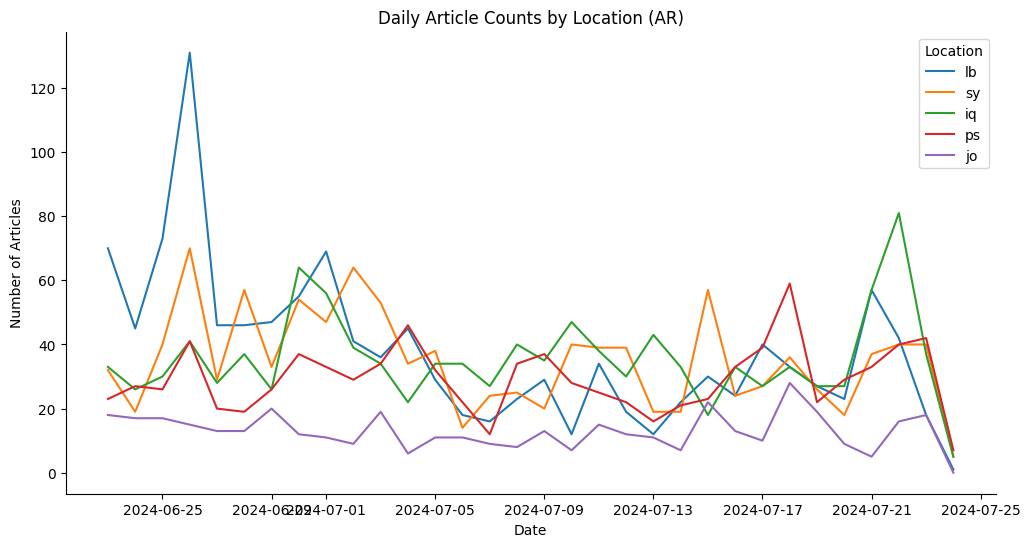

<Figure size 640x480 with 0 Axes>

In [86]:
_ = plt.figure(figsize=(12,6))

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

counter = collections.Counter(l for locs in df_news_ar['locations'] for l in locs)
counter = collections.Counter({k: v for k, v in counter.items() if len(k) == 2})  

# Just look at admin 0 for now

for location, v in counter.most_common():
    daily_counts = df_news_ar['locations'].map(lambda rfs: location in rfs).groupby(df_news_ar['dateTime'].dt.date).sum()
    daily_counts.plot(label=location)
    #print(location, daily_counts)

plt.legend(title="Location")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.title("Daily Article Counts by Location (AR)")
plt.show()

_ = plt.savefig("../reports/figures/daily_article_counts_by_location_ar.png", bbox_inches='tight',dpi = 300)

### Country level correlations

Daily count of articles mentioning each admin 0

In [53]:
counter_ar = collections.Counter(l for locs in df_news_ar['locations'] for l in locs)
counter_ar = collections.Counter({k: v for k, v in counter_ar.items() if len(k) == 2})  

counter_en = collections.Counter(l for locs in df_news_en['locations'] for l in locs)
counter_en = collections.Counter({k: v for k, v in counter_en.items() if len(k) == 2})  


In [54]:
for location, v in counter_ar.most_common():
    daily_counts_ar = df_news_ar['locations'].map(lambda rfs: location in rfs).groupby(df_news_ar['dateTime'].dt.date).sum()
    daily_counts_en = df_news_en['locations'].map(lambda rfs: location in rfs).groupby(df_news_en['dateTime'].dt.date).sum()

    print('For {:s} correlation: {:.2f}'.format(location, daily_counts_en.corr(daily_counts_ar)))

For lb correlation: 0.43
For sy correlation: 0.48
For iq correlation: 0.16
For ps correlation: 0.44
For jo correlation: 0.51


Now daily count of risk factors

In [59]:
counter_en = collections.Counter(rf for rfs in df_news_en['risk_factors'] for rf in rfs)
counter_ar = collections.Counter(rf for rfs in df_news_ar['risk_factors'] for rf in rfs)
del counter_ar[None]
del counter_en[None]

for risk_factor, v in counter_en.most_common():
    daily_counts_en = df_news_en['risk_factors'].map(lambda rfs: risk_factor in rfs).groupby(df_news_en['dateTime'].dt.date).sum()
    daily_counts_ar = df_news_ar['risk_factors'].map(lambda rfs: risk_factor in rfs).groupby(df_news_ar['dateTime'].dt.date).sum()

    print('For {:s} correlation: {:.2f}'.format(risk_factor, daily_counts_en.corr(daily_counts_ar)))

For forced displacement correlation: 0.22
For conflicts and violence correlation: 0.50
For other correlation: 0.55
For land-related issues correlation: 0.23
For political instability correlation: 0.28
For humanitarian aid correlation: nan


/Users/alexisrutherford/dime_take_home/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/alexisrutherford/dime_take_home/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Now look at admin 1 sparsity

EN

In [78]:
for c in ['iq','jo','lb','sy','ps']:
    counter_en = collections.Counter(l for locs in df_news_en['locations'] for l in locs)
    counter_en = collections.Counter({k: v for k, v in counter_en.items() if len(k) == 5 and k.startswith(c)})

    print(c)
    #print(counter_en)
    total_admin1 = len([k for k in locations_dict_en.keys() if k.startswith(c) and len(k) == 5])
    non_zero_admin1 = len(counter_en.keys())
    percent_non_zero = (non_zero_admin1 / total_admin1 * 100) if total_admin1 else 0
    print('{:d} out of {:d} admin level 1 are non-zero >>>> {:.1f}%'.format(non_zero_admin1, total_admin1, percent_non_zero))


iq
14 out of 18 admin level 1 are non-zero >>>> 77.8%
jo
0 out of 12 admin level 1 are non-zero >>>> 0.0%
lb
4 out of 8 admin level 1 are non-zero >>>> 50.0%
sy
1 out of 14 admin level 1 are non-zero >>>> 7.1%
ps
1 out of 2 admin level 1 are non-zero >>>> 50.0%


AR

In [79]:
for c in ['iq','jo','lb','sy','ps']:
    counter_ar = collections.Counter(l for locs in df_news_ar['locations'] for l in locs)
    counter_ar = collections.Counter({k: v for k, v in counter_ar.items() if len(k) == 5 and k.startswith(c)})

    print(c)
    #print(counter_en)
    total_admin1 = len([k for k in locations_dict_ar.keys() if k.startswith(c) and len(k) == 5])
    non_zero_admin1 = len(counter_ar.keys())
    percent_non_zero = (non_zero_admin1 / total_admin1 * 100) if total_admin1 else 0
    print('{:d} out of {:d} admin level 1 are non-zero >>>> {:.1f}%'.format(non_zero_admin1, total_admin1, percent_non_zero))


iq
11 out of 18 admin level 1 are non-zero >>>> 61.1%
jo
8 out of 12 admin level 1 are non-zero >>>> 66.7%
lb
5 out of 8 admin level 1 are non-zero >>>> 62.5%
sy
1 out of 14 admin level 1 are non-zero >>>> 7.1%
ps
2 out of 2 admin level 1 are non-zero >>>> 100.0%


## Now look at admin 2 sparsity

EN

iq
48 out of 126 admin level 2 are non-zero >>>> 38.1%
jo
15 out of 63 admin level 2 are non-zero >>>> 23.8%
lb
17 out of 27 admin level 2 are non-zero >>>> 63.0%
sy
34 out of 66 admin level 2 are non-zero >>>> 51.5%
ps
15 out of 16 admin level 2 are non-zero >>>> 93.8%


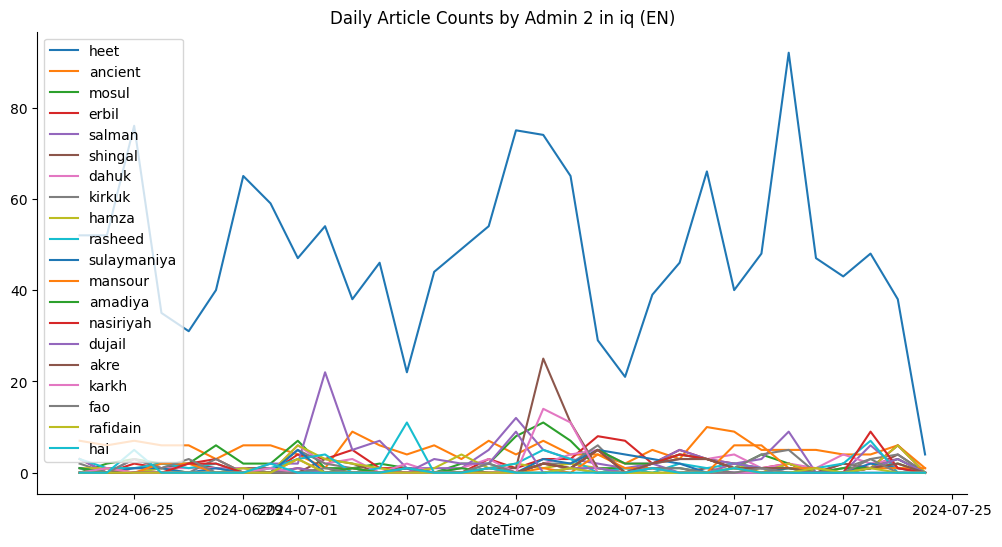

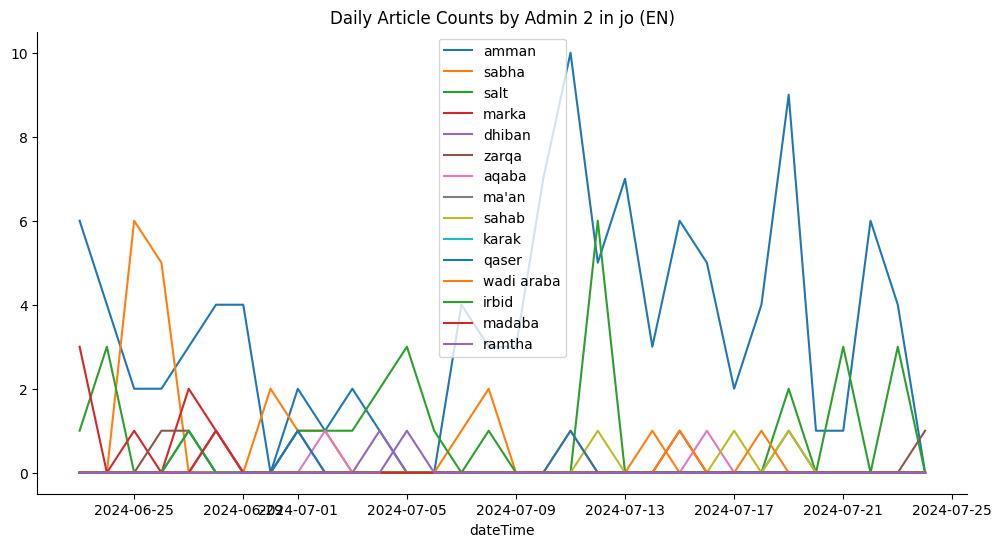

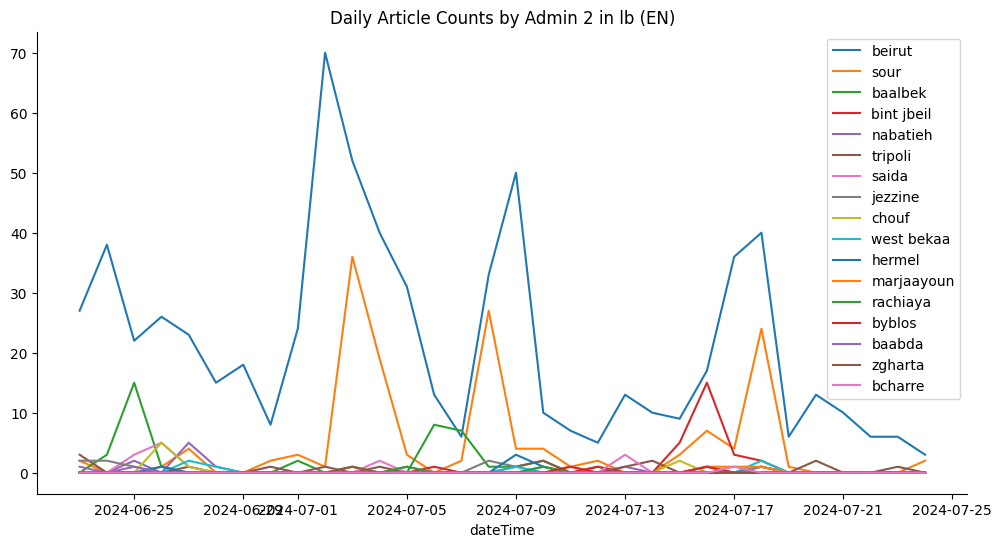

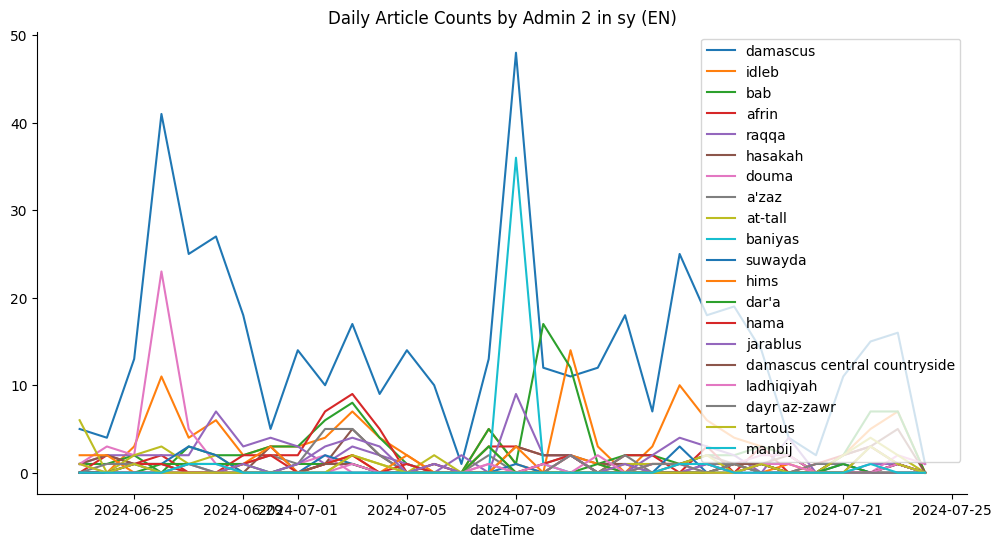

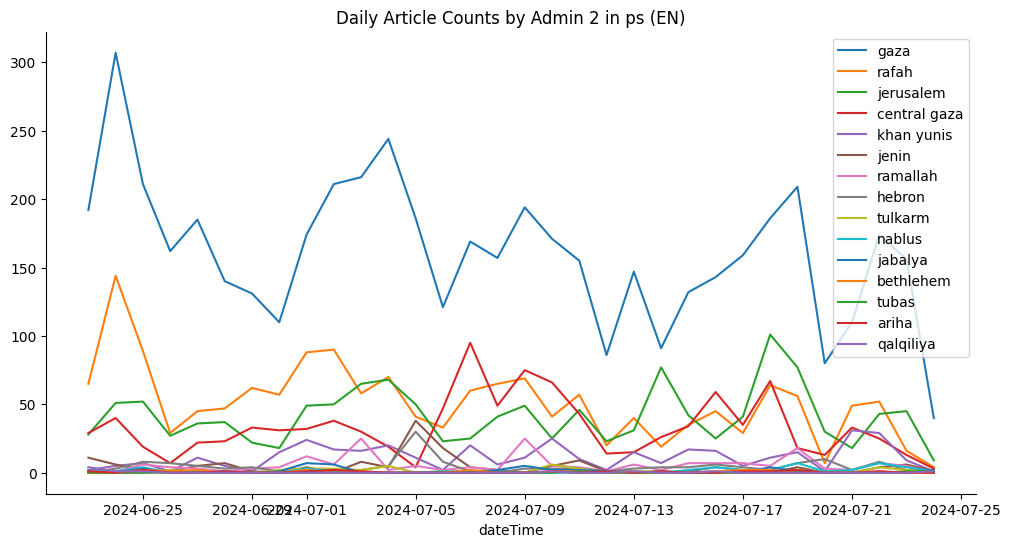

In [125]:
for c in ['iq','jo','lb','sy','ps']:
    
    _ = plt.figure(figsize=(12,6))

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    counter_en = collections.Counter(l for locs in df_news_en['locations'] for l in locs)
    counter_en = collections.Counter({k: v for k, v in counter_en.items() if len(k) > 5 and k.startswith(c)})

    print(c)
    #print(counter_en)
    total_admin2 = len([k for k in locations_dict_en.keys() if k.startswith(c) and len(k) > 5])
    non_zero_admin2 = len(counter_en.keys())
    percent_non_zero = (non_zero_admin2 / total_admin2 * 100) if total_admin2 else 0
    print('{:d} out of {:d} admin level 2 are non-zero >>>> {:.1f}%'.format(non_zero_admin2, total_admin2, percent_non_zero))
    
    counter = collections.Counter(l for locs in df_news_en['locations'] for l in locs)
    counter = collections.Counter({k: v for k, v in counter.items() if len(k) > 5 and k.startswith(c)})  

    for location, v in counter.most_common()[0:20]:
        # Can't fit more than 20 on a plot
        # TODO do this more cleanly with a groupby()
        daily_counts = df_news_en['locations'].map(lambda rfs: location in rfs).groupby(df_news_en['dateTime'].dt.date).sum()
        daily_counts.plot(label=locations_dict_en[location][0])
        #print(location, daily_counts)
    plt.title("Daily Article Counts by Admin 2 in {:s} (EN)".format(c))
    ax.legend()
    if False:
        plt.show()

    _ = plt.savefig("../reports/figures/daily_article_counts_by_admin_2_en_{:s}.png".format(c), bbox_inches='tight',dpi = 300)


AR

iq
66 out of 126 admin level 2 are non-zero >>>> 52.4%
jo
22 out of 63 admin level 2 are non-zero >>>> 34.9%
lb
24 out of 27 admin level 2 are non-zero >>>> 88.9%
sy
49 out of 66 admin level 2 are non-zero >>>> 74.2%
ps
15 out of 16 admin level 2 are non-zero >>>> 93.8%


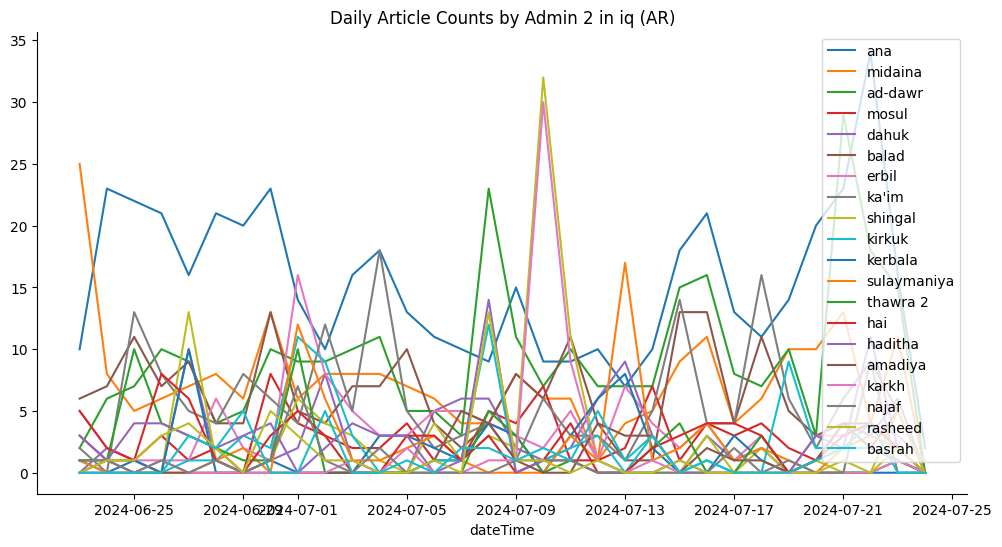

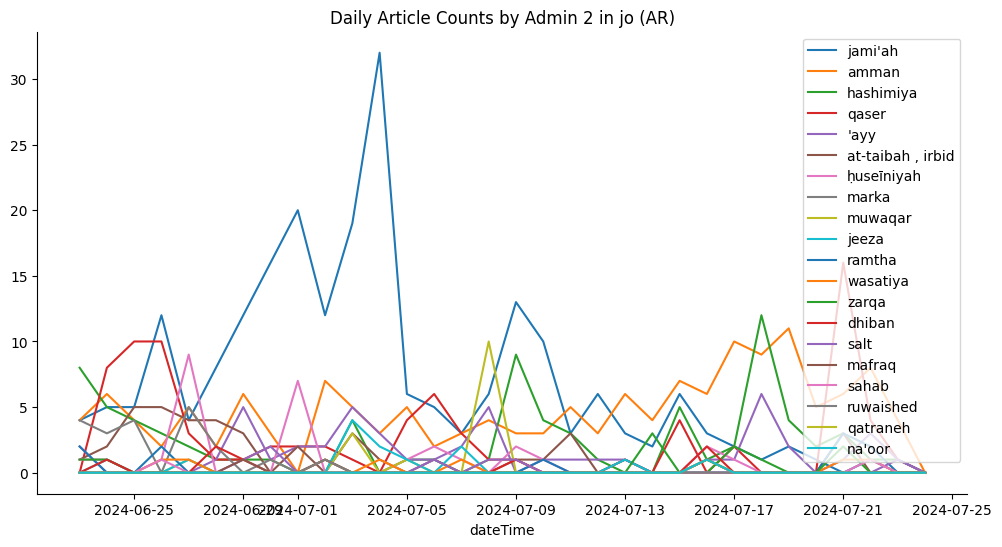

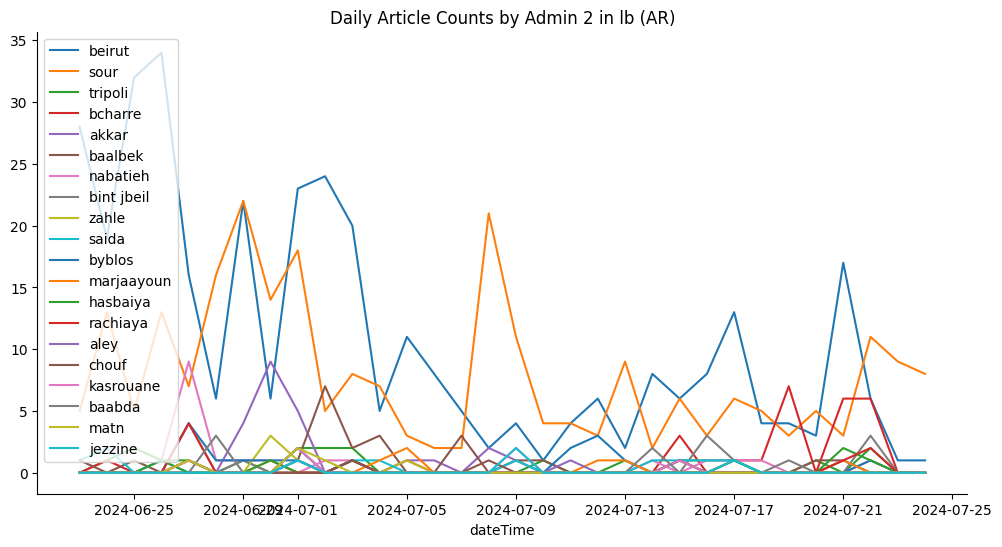

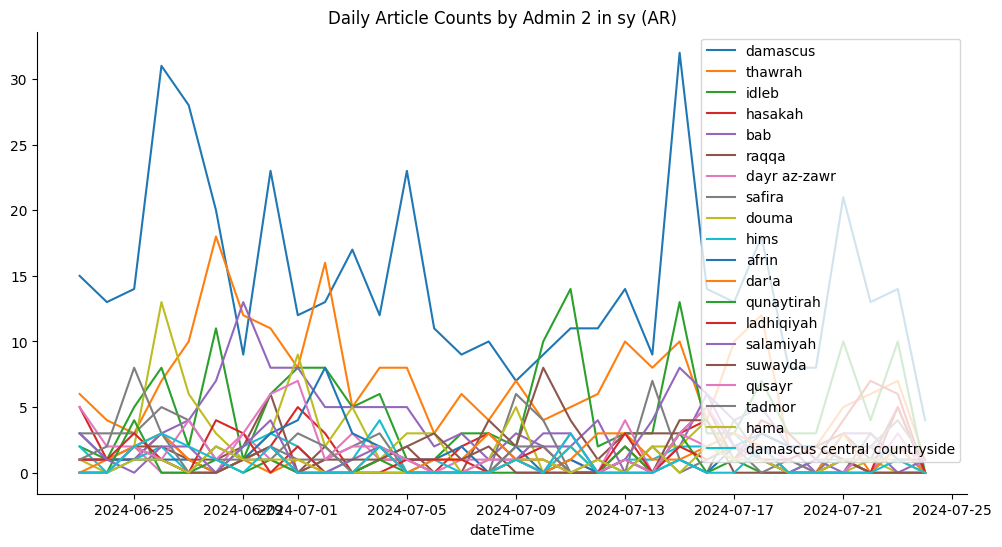

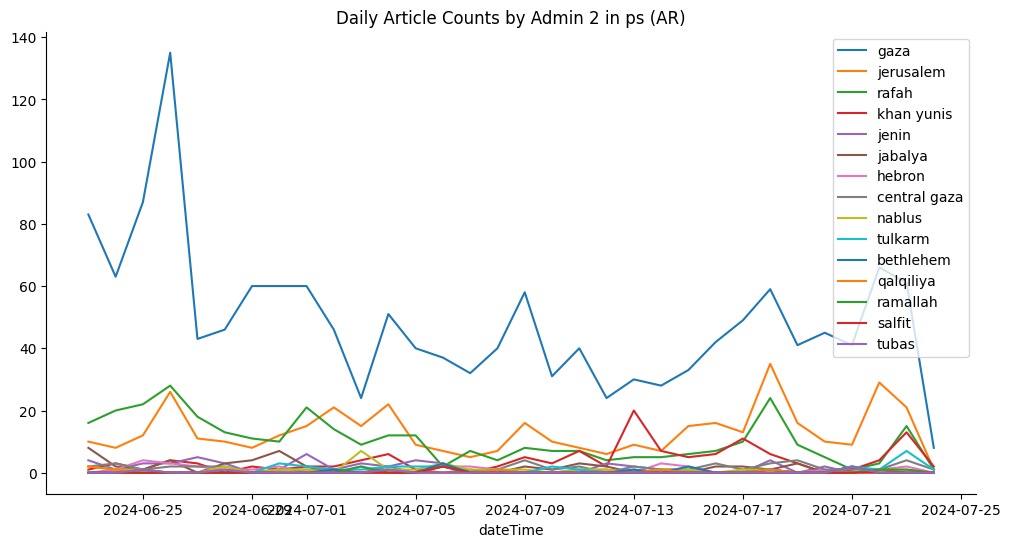

In [ ]:
for c in ['iq','jo','lb','sy','ps']:
    
    _ = plt.figure(figsize=(12,6))

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    counter_ar = collections.Counter(l for locs in df_news_ar['locations'] for l in locs)
    counter_ar = collections.Counter({k: v for k, v in counter_ar.items() if len(k) > 5 and k.startswith(c)})

    print(c)
    
    total_admin2 = len([k for k in locations_dict_ar.keys() if k.startswith(c) and len(k) > 5])
    non_zero_admin2 = len(counter_ar.keys())
    percent_non_zero = (non_zero_admin2 / total_admin2 * 100) if total_admin2 else 0
    print('{:d} out of {:d} admin level 2 are non-zero >>>> {:.1f}%'.format(non_zero_admin2, total_admin2, percent_non_zero))

    counter = collections.Counter(l for locs in df_news_ar['locations'] for l in locs)
    counter = collections.Counter({k: v for k, v in counter.items() if len(k) > 5 and k.startswith(c)})  

    for location, v in counter.most_common()[0:20]:
        # Can't fit more than 20 on a plot
        # TODO do this more cleanly with a groupby()
        daily_counts = df_news_ar['locations'].map(lambda rfs: location in rfs).groupby(df_news_ar['dateTime'].dt.date).sum()
        daily_counts.plot(label=locations_dict_en[location][0])
        # Add English label
        #print(location, daily_counts)
    plt.title("Daily Article Counts by Admin 2 in {:s} (AR)".format(c))
    ax.legend()
    if False:
        plt.show()

    _ = plt.savefig("../reports/figures/daily_article_counts_by_admin_2_ar_{:s}.png".format(c), bbox_inches='tight',dpi = 300)


The Arabic corpus has more complete coverage of admin level 2 areas of all countries.

# TODO

- ~~Do some simple correltations over time between risk factors and locations EN/AR~~
- ~~Do a mega multi-plot showing data points in each sub-national area~~
- ~~Try to get some ground truth data from e.g. World Bank API~~
- Add some detail in README